# Python data processing task
### Duc-Trung Hoang

In [384]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import r2_score
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 1. Clean the file
### 1.1 Load data

We first load the data using Pandas. Then we print out first and last 5 rows of the data

In [385]:
df = pd.read_csv('conso.csv', parse_dates=['timestamp'])
df.head()

,timestamp,consumption,unit_consumption,temperature,unit_temperature
0,2018-01-01 00:00:00,9,Wh,11.9,C
1,2018-01-01 00:01:00,11,Wh,11.9,C
2,2018-01-01 00:02:00,8,Wh,11.9,C
3,2018-01-01 00:03:00,7,Wh,11.9,C
4,2018-01-01 00:04:00,6,Wh,11.9,C


In [386]:
df.tail()

,timestamp,consumption,unit_consumption,temperature,unit_temperature
525595,2018-12-31 23:55:00,7,Wh,10.5,C
525596,2018-12-31 23:56:00,7,Wh,10.5,C
525597,2018-12-31 23:57:00,7,Wh,10.5,C
525598,2018-12-31 23:58:00,7,Wh,10.5,C
525599,2018-12-31 23:59:00,7,Wh,10.5,C


We can see that the time run from the beginning of 2018 to the end of 2018 (timezone Europe/Paris), and the data for every minute.

We now print out the shape of the data, which means we have 525000 rows and 4 columns (not count the timestamp)

In [387]:
df.shape

(525600, 5)

The following equation shows that we don't miss timestamp for any minute during the year

In [388]:
525600 == 365 * 24 * 60

True

### 1.2. Remove unecessary columns

We convert the list of unit temperature into set, which return only 1 value, Celcius degree

In [389]:
set(df.unit_temperature)

{'C'}

The same for unit consumption

In [390]:
set(df.unit_consumption)

{'Wh'}

In [391]:
df = df.drop(columns = ['unit_temperature','unit_consumption'])

In [392]:
df.head()

,timestamp,consumption,temperature
0,2018-01-01 00:00:00,9,11.9
1,2018-01-01 00:01:00,11,11.9
2,2018-01-01 00:02:00,8,11.9
3,2018-01-01 00:03:00,7,11.9
4,2018-01-01 00:04:00,6,11.9


### Timestamp as index

In [393]:
df.index =  df['timestamp']
df = df.drop(columns = ['timestamp'])

In [394]:
df.head()

,consumption,temperature
timestamp,,
2018-01-01 00:00:00,9,11.9
2018-01-01 00:01:00,11,11.9
2018-01-01 00:02:00,8,11.9
2018-01-01 00:03:00,7,11.9
2018-01-01 00:04:00,6,11.9


### Temperature column

We print out every possible value of temperature column, and all of them of type float, so there is no problem here

In [395]:
print(set(df.temperature))

{0.7, 1.6, 2.1, 3.0, 4.8, 5.2, 6.1, 7.9, 8.9, 9.6, 10.5, 10.8, 11.8, 11.9, 10.4, 14.7, 10.6, 11.3, 11.4, 10.1, 13.1, 12.1, 15.0, 15.4, 15.7, 16.2, 17.0, 18.1, 4.5, 4.0, 5.0, 6.5, 6.0, -0.5, 1.0, 26.6, 7.5, 7.0, 29.7, 30.5, 31.0, 8.0, 8.5, 9.0, 9.5, 10.0, 11.0, 11.5, 2.5, 12.5, 12.0, 13.5, 13.0, 14.0, 14.5, 17.2, 15.5, 24.1, 16.1, 16.5, 16.4, 3.5, 16.0, 17.1, 16.9, 17.4, 17.9, 16.6, 18.4, 18.6, 17.6, 18.5, 17.5, 19.1, 19.9, 19.6, 19.0, 19.4, 20.5, 1.4, 1.9, 19.5, 20.1, 21.0, 2.9, 2.4, 21.6, 20.0, 22.0, 22.5, 22.9, 21.5, 21.1, 23.0, 23.4, 23.6, 23.1, 22.1, 24.9, 23.5, 24.5, 24.0, 24.4, 25.1, 25.0, 25.6, 25.9, 24.6, 26.1, 26.0, 26.5, 26.9, 26.4, 27.9, 27.4, 27.0, 27.1, 27.5, 28.0, 28.4, 28.1, 28.6, 28.5, 29.5, 29.0, 29.4, 4.9, 4.4, 29.9, 29.1, 30.6, 5.9, 5.4, 30.0, 30.1, 30.4, 6.4, 6.9, 32.1, 7.4, 33.2, 33.0, 8.4, 33.8, 9.9, 9.4, 10.9, 12.9, 12.4, -0.1, 13.9, 13.4, 14.4, 14.9, 20.6, 22.4, 15.9, 3.8, 3.3, 4.3, 5.8, 5.3, 6.8, 6.3, 7.8, 7.3, 18.9, 22.6, -0.9, 0.4, 0.6, 8.8, 8.7, 8.2, 8.3, 20

### Consumption column

We now explore the consumption column by first print out all the values in the column

In [396]:
print(set(df.consumption))

{nan, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, '42', '57', 16, 17, 15, 14, 20, 21, 22, 23, '43', '18', '64', 26, 28, 25, 24, 27, 32, 33, 31, 35, 36, 37, 38, 39, 40, 41, 42, 43, '48', 44, 46, 47, 48, 45, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, '45', 61, 63, 64, 62, 66, 67, 65, 68.0, 69.0, 71, 70.0, 73.0, 74.0, 75, 76.0, '68', '71', '86', 77, 78.0, 82.0, 80.0, 79.0, 85, 83, 81, 90.0, 18, '34', 19, '4', '56', '44', '88', '3', '247', '24', 29, '69', 30, '1', '11', '76', nan, '46', '51', '52', '49', '2', '5', '36', 34, '40', '79', '14', '27', '62', '19', '26', '13', '-', '65', '73', '0', '15', '55', 49, '25', '28', '8', '77', '72', '32', '33', '47', '35', '21', '7', '63', '10', '61', '38', '59', '41', '30', '54', '17', '23', 72.0, '58', '31', '60', '50', '6', '29', '16', '67', '9', '37', '74', '53', '20', '70', '66', '22', '39', '12'}


We see here there are 3 types: 
    - a tring of integer like '56'
    - an int or float type, like 2 or 72.0
    - the tring '-', which should be considered as a missing value
    - nan type, which should be considered as a missing value

We first handle NaN type

In [397]:
df[df.consumption.isna()]

,consumption,temperature
timestamp,,
2018-09-07 14:54:00,NaN,26.6
2018-09-07 14:55:00,NaN,26.6


They fall into two consecutive minutes. We print out the time arounds

In [398]:
df['2018-09-07 14:50:00':'2018-09-07 14:59:00']

,consumption,temperature
timestamp,,
2018-09-07 14:50:00,11,26.6
2018-09-07 14:51:00,11,26.6
2018-09-07 14:52:00,12,26.6
2018-09-07 14:53:00,12,26.6
2018-09-07 14:54:00,NaN,26.6
2018-09-07 14:55:00,NaN,26.6
2018-09-07 14:56:00,6,26.6
2018-09-07 14:57:00,12,26.6
2018-09-07 14:58:00,12,26.6


With this info, we can go for 12 as missing values

In [399]:
df = df.fillna(12)

And the NaN disappear as we can see

In [400]:
df[df.consumption.isna()]

,consumption,temperature
timestamp,,


We now explore the missing '-'

In [401]:
df[df.consumption == '-']

,consumption,temperature
timestamp,,
2018-03-02 05:16:00,-,6.1
2018-03-02 05:17:00,-,6.1
2018-03-02 05:18:00,-,6.1
2018-03-02 05:19:00,-,6.1
2018-03-02 05:20:00,-,6.1
2018-03-02 05:21:00,-,6.1
2018-03-02 05:22:00,-,6.1
2018-03-02 05:23:00,-,6.1
2018-03-02 05:24:00,-,6.1


This shows that all the missing '-' fall in the same day, in only 1 hour. We again print out the values around that time

In [402]:
print(list(df.consumption['2018-03-02 03:00:00':'2018-03-02 08:20:00']))

['12', '11', '10', '10', '9', '9', '8', '9', '7', '6', '7', '6', '8', '7', '7', '8', '7', '8', '8', '9', '9', '10', '10', '12', '12', '13', '13', '12', '12', '12', '12', '12', '12', '11', '11', '11', '10', '10', '11', '11', '11', '11', '11', '11', '10', '11', '10', '11', '12', '12', '12', '11', '11', '10', '9', '9', '9', '8', '9', '9', '10', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '10', '10', '10', '10', '10', '9', '9', '9', '9', '9', '9', '9', '10', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '15', '17', '18', '45', '47', '46', '44', '45', '45', '45', '44', '45', '46', '45', '46', '45', '46', '25', '15', '16', '20', '21', '19', '18', '17', '17', '17', '16', '17', '26', '23', '22', '16', '15', '15', '13', '4', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '1',

There is some extreme fluctuation around the missing values (as high as 247). Maybe there is some errors here. The part before get around 10, while the part after get around 4. So we choose 7 as the missing values. We will handle the abnormal values later on.

In [403]:
df.consumption = df.consumption.replace('-',7)

In [404]:
df[df.consumption == '-']

,consumption,temperature
timestamp,,


So there is no more '-'. We still have string type we need to convert to float. We do so by list comprehension.

In [405]:
df.consumption  = [float(i) for i in df.consumption]

Right now, all values in consupmtion and temperature columns are numbers. We can have a quick look at statistics

In [406]:
df.describe()

,consumption,temperature
count,525600.000000,525600.000000
mean,10.183921,16.442158
std,9.556944,6.345226
min,0.000000,-1.200000
25%,5.000000,11.500000
50%,7.000000,16.400000
75%,12.000000,21.100000
max,247.000000,33.800000


There is nothing wrong with temperature, max 33 degree, min -1 degree, mean 16 degree, which match the expectation of the temperature in France

For the consuption, there is some extreme at the max 247 (min 0 is normal). We print all unique values of consumption and its counts

In [407]:
np.unique(df.consumption, return_counts = True)

(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  85.,  86.,  88.,  90.,
        247.]),
 array([   45,    11,   391,  5028, 67433, 66682, 80142, 67607, 39506,
        25100, 23563, 18133, 17331, 15651, 13800, 11239,  8822,  6085,
         4312,  2874,  2893,  2937,  2901,  3169,  5193,  5484,  5482,
         4069,  2492,  1658,  1238,  1219,  1169,  1000,   859,   622,
          556,   545,   617,   688,   581,   441,   364,   352,   335,
          255,   166,    98,    88,  

We observe that it falls mainly in 3 to 40, and can achieve maximum at 90 at many points. This raises an assumption that 90 and 247 are abnormal values.

To check that, we save the abnormal values in a csv file and print out all of their values

In [418]:
pd.concat([df[df.consumption == 247],df[df.consumption == 90]]).to_csv('D:/donnes_aberrantes.csv')

In [196]:
i90 = df[df.consumption == 90].index

By printing the beginning and the end of the period of 90 consumption, we see that it is in the range of only 3 days

In [197]:
print(min(i90), max(i90))

2018-09-26 18:21:00 2018-09-29 03:26:00


We plot the consumption of the event with +- 3 days

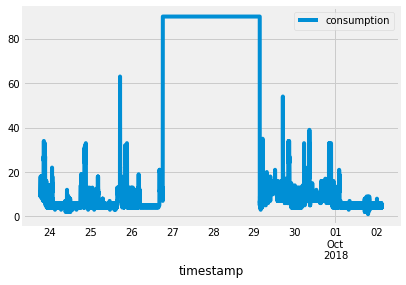

In [198]:
df.consumption['2018-09-23 18:21:00':'2018-10-02 03:26:00'].plot(legend=True)

This is clearly abnormal, we replace by average of 3 previous days and 3 days afterward

In [199]:
before = np.mean(df.consumption['2018-09-23 18:21:00':'2018-09-26 18:21:00'])
after = np.mean(df.consumption['2018-09-29 03:26:00':'2018-10-02 03:26:00'])
df.consumption[i90] = (before + after)/2

Now, things look good

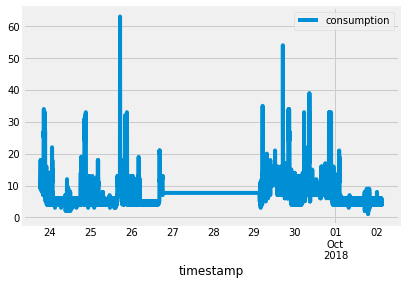

In [200]:
df.consumption['2018-09-23 18:21:00':'2018-10-02 03:26:00'].plot(legend=True)

There is a single 247 value

In [201]:
df[df.consumption == 247]

,consumption,temperature
timestamp,,
2018-03-02 06:06:00,247.0,6.7


We replace it by the average of 6 hours around it

In [202]:
df.consumption['2018-03-02 06:06:00'] = np.mean(df.consumption['2018-03-02 03:06:00':'2018-03-02 09:06:00'])

In [203]:
df.consumption['2018-03-02 06:06:00']

9.113573407202216

## 2. Graph of daily consumption

Sum of the daily consumption and average of daily temperature can be done simply by the following lines

In [204]:
daily_cons = df.consumption.resample('D',how='sum')

In [205]:
daily_temp = df.temperature.resample('D',how='mean')

And we merge them into a single data frame

In [206]:
daily = pd.DataFrame({'consumption':daily_cons,'temperature':daily_temp})

In [207]:
daily.head()

,consumption,temperature
timestamp,,
2018-01-01,15874.0,10.9750
2018-01-02,14512.0,10.8625
2018-01-03,9466.0,13.8375
2018-01-04,8311.0,14.7125
2018-01-05,15362.0,13.7625


We first plot the evolution of consumption and temperature seperately

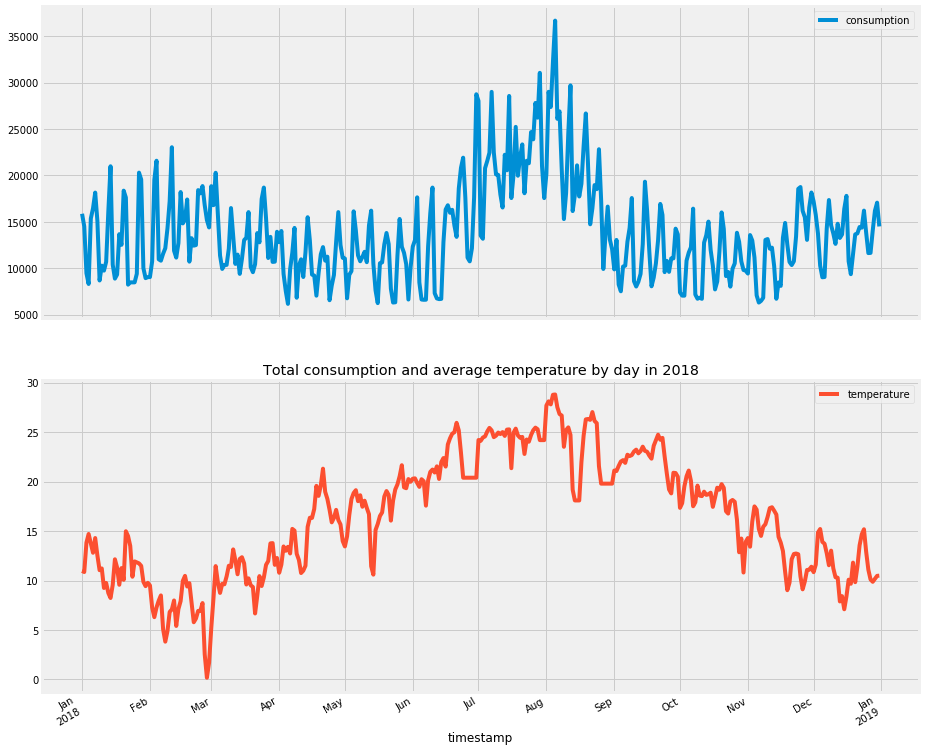

In [208]:
daily.plot(subplots=True, figsize=(14,14))
plt.title('Total consumption and average temperature by day in 2018')
plt.show()

We can easily see that consumption goes at peek in Jul Aug, mid consumption in the winter, and lowest in the fall and spring

We now use scatter to see the correlation between the two columns

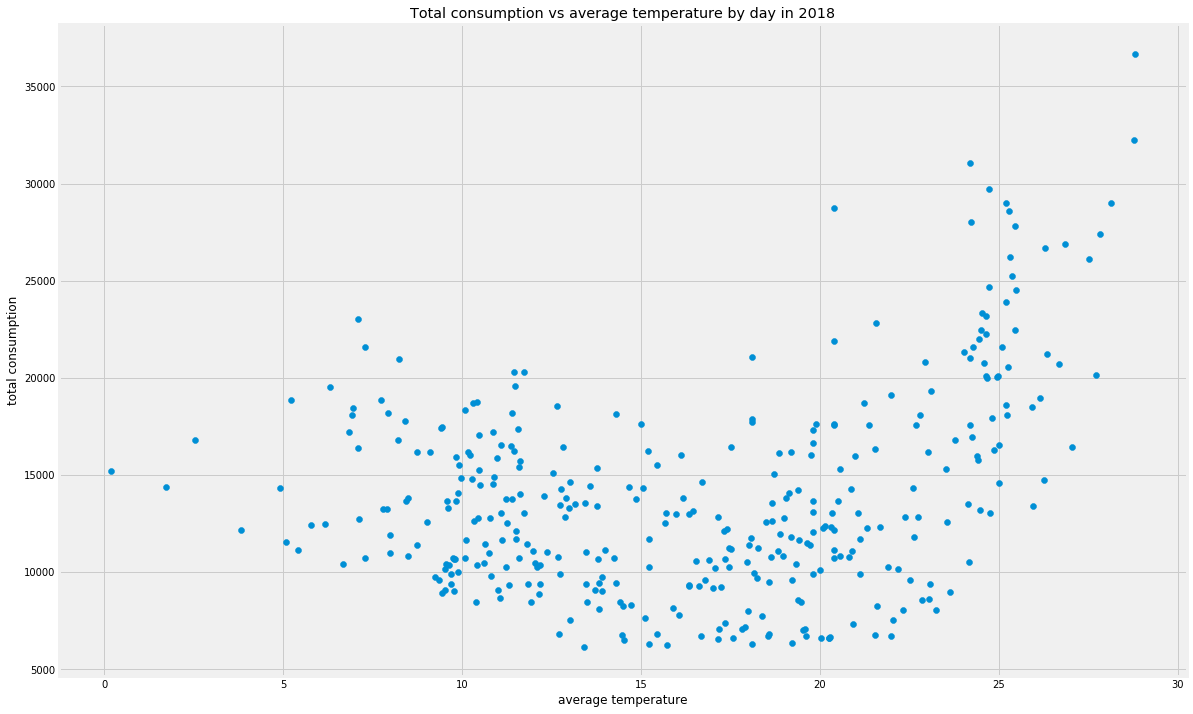

In [209]:
plt.figure(figsize=(18,12))
plt.scatter(daily.temperature, daily.consumption)
plt.title('Total consumption vs average temperature by day in 2018')
plt.xlabel('average temperature')
plt.ylabel('total consumption')
plt.show()

From this, we can again confirm the above observation is that the highest consumption when temperature is high (Jul, Aug), middle when temperate is low (winter) and lowest at around 15 degree (fall, spring).

## 3. Time Series Models

Family of Autoregressive models

#### Autoregressive (AR) model. 

The autoregressive model specifies that the output variable depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term).

#### Moving-average (MA) 

The moving-average model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.


#### Autoregressive–moving-average (ARMA) 

Autoregressive–moving-average models provide a parsimonious description of a (weakly) stationary stochastic process in terms of two polynomials, one for the autoregression and the second for the moving average. It's the fusion of AR and MA models.

#### Verdict: 
We will choose ARMA as it is more general comparing to AR and MA models. However, note that all the models above only make use of the information inside the timeseries, not from other time series. 

The documentation of ARMA is available here: https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARMA.html

In [261]:
daily.consumption

timestamp
2018-01-01    15874.0
2018-01-02    14512.0
2018-01-03     9466.0
2018-01-04     8311.0
2018-01-05    15362.0
2018-01-06    16460.0
2018-01-07    18156.0
2018-01-08    15096.0
2018-01-09     8686.0
2018-01-10    10285.0
2018-01-11     9748.0
2018-01-12    10697.0
2018-01-13    16166.0
2018-01-14    20993.0
2018-01-15    10394.0
2018-01-16     8886.0
2018-01-17     9327.0
2018-01-18    13676.0
2018-01-19    12528.0
2018-01-20    18364.0
2018-01-21    17621.0
2018-01-22     8237.0
2018-01-23     8482.0
2018-01-24     8482.0
2018-01-25     8482.0
2018-01-26     9412.0
2018-01-27    20306.0
2018-01-28    19568.0
2018-01-29    10014.0
2018-01-30     8938.0
               ...   
2018-12-02    15743.0
2018-12-03    13740.0
2018-12-04    10280.0
2018-12-05     9032.0
2018-12-06     9059.0
2018-12-07    14293.0
2018-12-08    17355.0
2018-12-09    14627.0
2018-12-10    13751.0
2018-12-11    12631.0
2018-12-12    14798.0
2018-12-13    13270.0
2018-12-14    13650.0
2018-12-15    16395.0


In [262]:
model = ARMA(daily.consumption, order=(1,1,1))
result = model.fit()
print(result.summary())


                              ARMA Model Results                              
Dep. Variable:            consumption   No. Observations:                  365
Model:                     ARMA(1, 1)   Log Likelihood               -3498.155
Method:                       css-mle   S.D. of innovations           3511.959
Date:                Sun, 01 Dec 2019   AIC                           7004.309
Time:                        22:34:46   BIC                           7019.909
Sample:                    01-01-2018   HQIC                          7010.509
                         - 12-31-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.389e+04    621.151     22.364      0.000    1.27e+04    1.51e+04
ar.L1.consumption     0.6506      0.055     11.797      0.000       0.543       0.759
ma.L1.consumption     0.

In [263]:
rmse = math.sqrt(mean_squared_error(daily.consumption.values, result.predict()))
print("The root mean squared error is {}.".format(rmse))

mae = mean_absolute_error(daily.consumption.values, result.predict())
print("The mean absolute error is {}.".format(mae))

r2 = r2_score(daily_copy.consumption.values, result.predict())
print("The R2 coefficient is {}.".format(r2))

The root mean squared error is 3512.810755899275.
The mean absolute error is 2657.9111189692258.
The R2 coefficient is 0.5508450248771827.


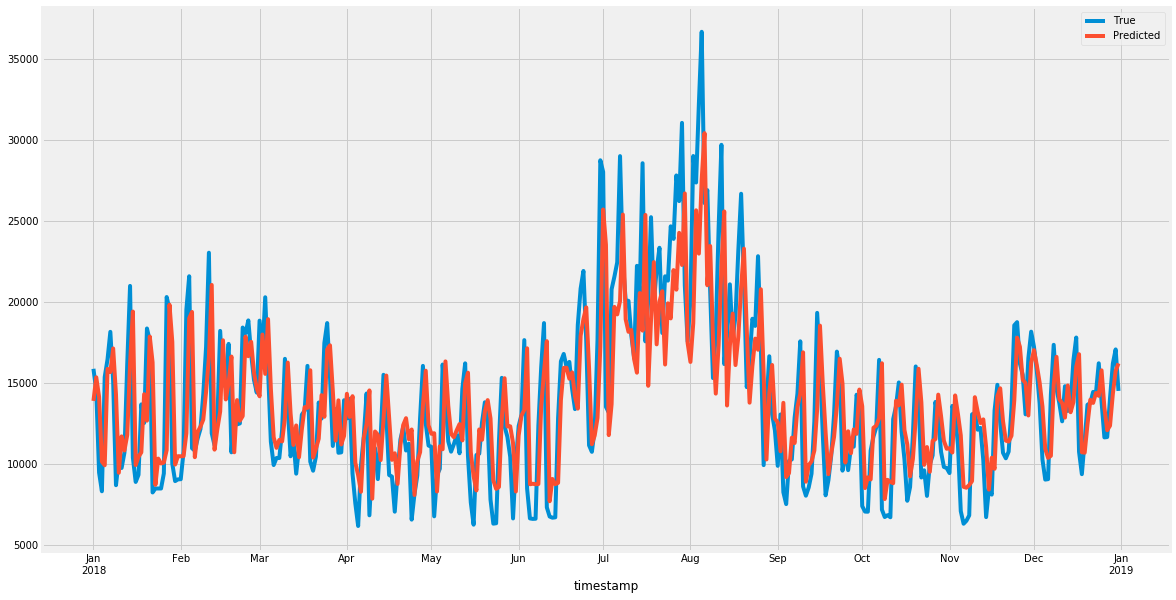

In [264]:
plt.figure(figsize=(18,10))
daily_copy.consumption.plot()
result.predict().plot()
plt.legend(['True','Predicted'])
plt.show()

The above graph shows us how ARMA model fit to the daily data of electric consumption. However, it is better for us to predict the electric consumption if we have the data of previous years since it would provide us more useful informations such as the seasonality, the average trend... 

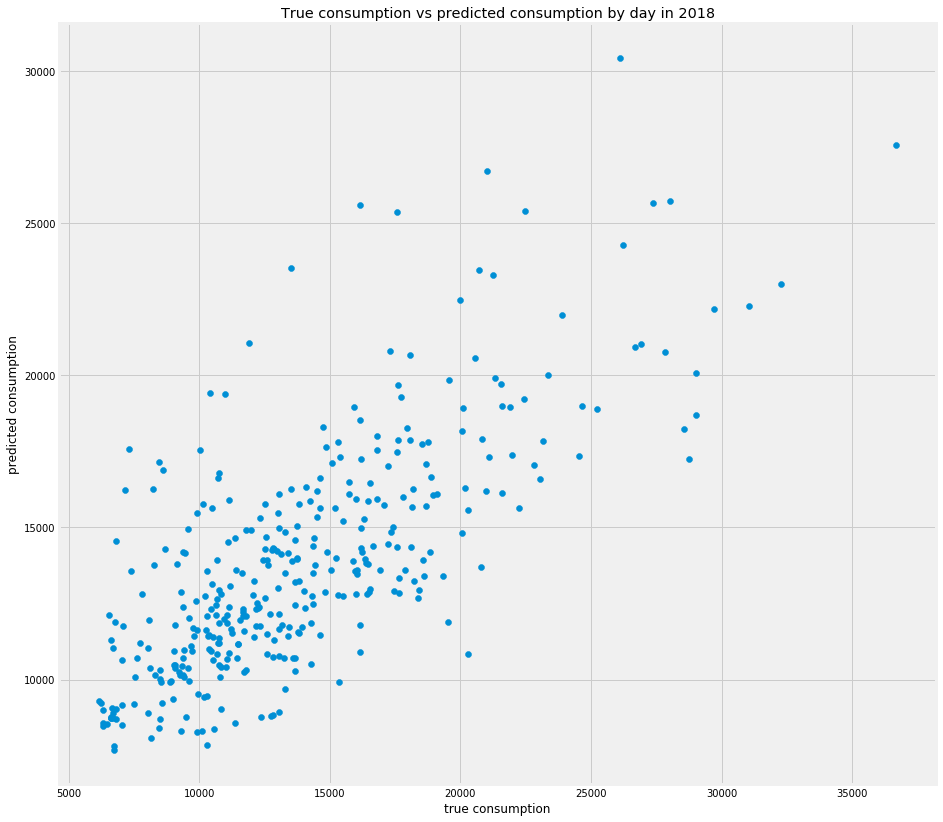

In [267]:
plt.figure(figsize=(14,14))
plt.scatter(daily_copy.consumption,result.predict())
plt.title('True consumption vs predicted consumption by day in 2018')
plt.xlabel('true consumption')
plt.ylabel('predicted consumption')
plt.show()

## 4. Machine Learning models to predict electric consumption

We aim to deal with supervised learning problem to use machine learning model. The electric consumption is assummed to depend on the temperature.

In [268]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [269]:
daily['day'] = np.arange(1,366)

We train the model up to the end of October 2018, and we predict the electric conssumation of the last two months in the year (November and December).

In [280]:
X = daily[['temperature']]
y = daily['consumption']

scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns)


X_train = X[:304].values
y_train = y[:304].values

X_test = X[304:].values
y_test = y[304:].values

We use Linear Regression model to predict the electric consumption of the last 60 days in 2018.

The root mean squared error is 3659.367023465162.
The mean absolute error is 3014.3527468983543.


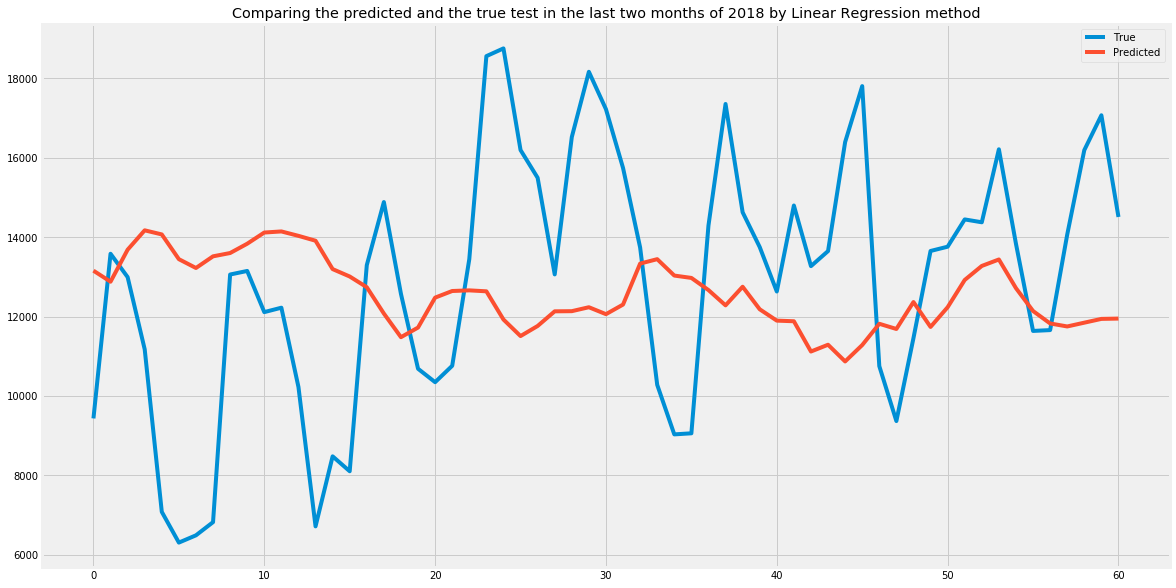

In [282]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_test_pred = lr.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
print("The root mean squared error is {}.".format(rmse))

mae = mean_absolute_error(y_test, y_test_pred)
print("The mean absolute error is {}.".format(mae))

plt.figure(figsize=(18,10))
pd.Series(y_test).plot()
pd.Series(y_test_pred).plot()
plt.legend(['True','Predicted'])
plt.title('Comparing the predicted and the true test in the last two months of 2018 by Linear Regression method')
plt.show()


We use Random Forest Regression model to predict the electric consumption of the last 60 days in 2018.

The root mean squared error is 3847.4336484567343.
The mean absolute error is 3198.3706284153004.


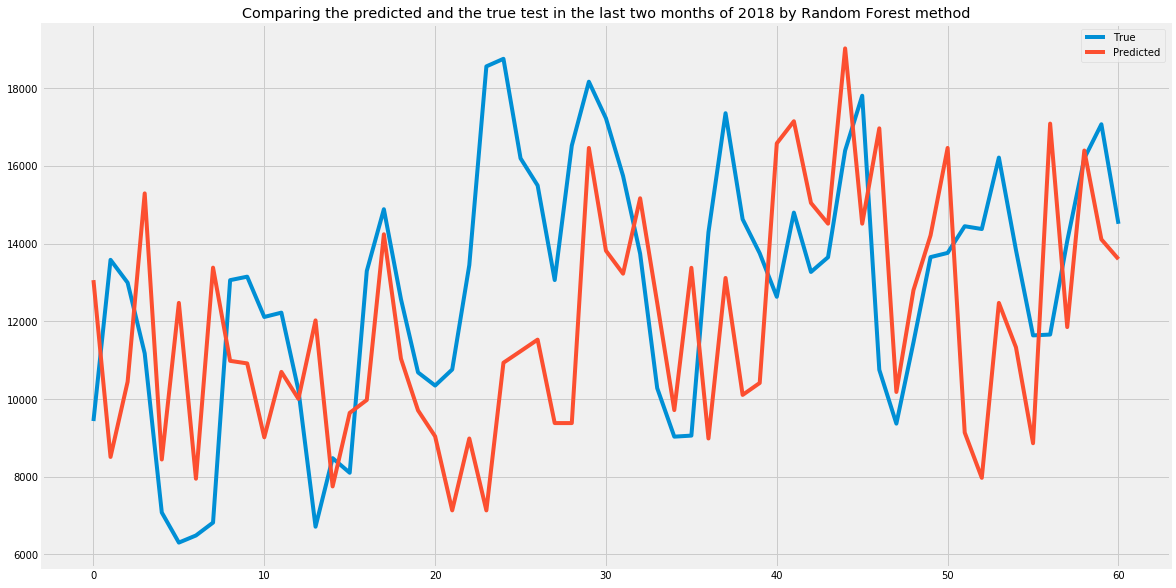

In [283]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
y_test_pred = rf.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
print("The root mean squared error is {}.".format(rmse))

mae = mean_absolute_error(y_test, y_test_pred)
print("The mean absolute error is {}.".format(mae))

plt.figure(figsize=(18,10))
pd.Series(y_test).plot()
pd.Series(y_test_pred).plot()
plt.legend(['True','Predicted'])
plt.title('Comparing the predicted and the true test in the last two months of 2018 by Random Forest method')
plt.show()


Comment: The Linear Regression seem to have slightly better RMSE and MAE score than Random Forest Regression. However, the Random Forest Regression shows us that the method could predict well the electric consumption due to some certain days. Since the electric consumption seem to be periodical for years, it is better if we have data from previous years. So that, the prediction could be very well. 